<a href="https://colab.research.google.com/github/vsisodiy/ML-Competitions/blob/master/Titanic_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of the notebook is to solve titanic problem of predicting who will survive.

We would proceed in the following steps:

1. 


References used

1. https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy


In [ ]:
%%capture
!pip install --upgrade --force-reinstall --no-deps kaggle
! pip install -q kaggle
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! mkdir ./titanic
! cd titanic
! kaggle competitions download -c titanic
! unzip titanic.zip
! rm -r titanic.zip

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 24.3MB/s]


In [ ]:
import sys 
print("Python version: {}". format(sys.version))
import pandas as pd 
print("pandas version: {}". format(pd.__version__))
import matplotlib 
print("matplotlib version: {}". format(matplotlib.__version__))
import numpy as np 
print("NumPy version: {}". format(np.__version__))
import scipy as sp
print("SciPy version: {}". format(sp.__version__)) 

import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
print("IPython version: {}". format(IPython.__version__)) 

import sklearn
print("scikit-learn version: {}". format(sklearn.__version__))

#misc libraries
import random
import time


Python version: 3.6.9 (default, Jul 17 2020, 12:50:27) 
[GCC 8.4.0]
pandas version: 1.0.5
matplotlib version: 3.2.2
NumPy version: 1.18.5
SciPy version: 1.4.1
IPython version: 5.5.0
scikit-learn version: 0.22.2.post1


In [ ]:
#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

#Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

#Configure Visualization Defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data_raw = pd.read_csv('train.csv')
data_val  = pd.read_csv('test.csv')
data1 = data_raw.copy(deep = True)
data_cleaner = [data1, data_val]

In [ ]:
print('Train columns with null values:\n', data1.isnull().sum())
print("-"*10)

print('Test/Validation columns with null values:\n', data_val.isnull().sum())
print("-"*10)

data_raw.describe(include = 'all')

Train columns with null values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
Test/Validation columns with null values:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
----------


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Kallio, Mr. Nikolai Erland",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [ ]:
for dataset in data_cleaner:    
    #complete missing age with median
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    #complete embarked with mode
    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    #complete missing fare with median
    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
#delete the cabin feature/column and others previously stated to exclude in train dataset
drop_column = ['PassengerId','Cabin', 'Ticket']
for dataset in data_cleaner: 
    dataset.drop(drop_column, axis=1, inplace = True)

#to check the data after fillna operation 
print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())


Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [ ]:
#preview data again
data1.info()
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       891 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Fare      891 non-null    float64
 8   Embarked  891 non-null    object 
dtypes: float64(2), int64(4), object(3)
memory usage: 62.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       418 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null

Some of the methods to convert the categorical featrues into dummy variables

* Categorical Encoding
* Sklearn LabelEncoder
* Sklearn OneHotEncoder
* Pandas Categorical dtype
* pandas.get_dummies

In [ ]:
data1.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [ ]:
for dataset in data_cleaner:    
    #Continuous variable bins; qcut vs cut: https://stackoverflow.com/questions/30211923/what-is-the-difference-between-pandas-qcut-and-pandas-cut
    #Fare Bins/Buckets using qcut or frequency bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html
    dataset['FareBin'] = pd.qcut(dataset['Fare'], 4)

    #Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int), 5)


In [ ]:
label = LabelEncoder()
for dataset in data_cleaner:    
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['AgeBin'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

In [ ]:
#define y variable aka target/outcome
Target = ['Survived']

#define x variables for original features aka feature selection
data1_x = ['Sex','Pclass', 'Embarked','SibSp', 'Parch', 'Age', 'Fare']
data1_x_calc = ['Sex_Code','Pclass', 'Embarked_Code','SibSp', 'Parch', 'Age', 'Fare'] #coded for algorithm calculation
data1_xy =  Target + data1_x
print('Original X Y: ', data1_xy, '\n')


#define x variables for original w/bin features to remove continuous variables
data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'AgeBin_Code', 'FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y: ', data1_xy_bin, '\n')


#define x and y variables for dummy features original
data1_dummy = pd.get_dummies(data1[data1_x])
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y: ', data1_xy_dummy, '\n')



data1_dummy.head()

Original X Y:  ['Survived', 'Sex', 'Pclass', 'Embarked', 'SibSp', 'Parch', 'Age', 'Fare'] 

Bin X Y:  ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y:  ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S'] 



,Pclass,SibSp,Parch,Age,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,1,0,22.0,7.2500,0,1,0,0,1
1,1,1,0,38.0,71.2833,1,0,1,0,0
2,3,0,0,26.0,7.9250,1,0,0,0,1
3,1,1,0,35.0,53.1000,1,0,0,0,1
4,3,0,0,35.0,8.0500,0,1,0,0,1


In [ ]:
#split train and test data with function defaults
#random_state -> seed or control random number generator: https://www.quora.com/What-is-seed-in-random-number-generation
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(data1[data1_x_calc], data1[Target], random_state = 0)
train1_x_bin, test1_x_bin, train1_y_bin, test1_y_bin = model_selection.train_test_split(data1[data1_x_bin], data1[Target] , random_state = 0)
train1_x_dummy, test1_x_dummy, train1_y_dummy, test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy], data1[Target], random_state = 0)


print("Data1 Shape: {}".format(data1.shape))
print("Train1 Shape: {}".format(train1_x.shape))
print("Test1 Shape: {}".format(test1_x.shape))

train1_x_bin.head()

Data1 Shape: (891, 15)
Train1 Shape: (668, 7)
Test1 Shape: (223, 7)


,Sex_Code,Pclass,Embarked_Code,AgeBin_Code,FareBin_Code
105,1,3,2,1,0
68,0,3,2,1,1
253,1,3,2,1,2
320,1,3,2,1,0
706,0,2,2,2,1


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


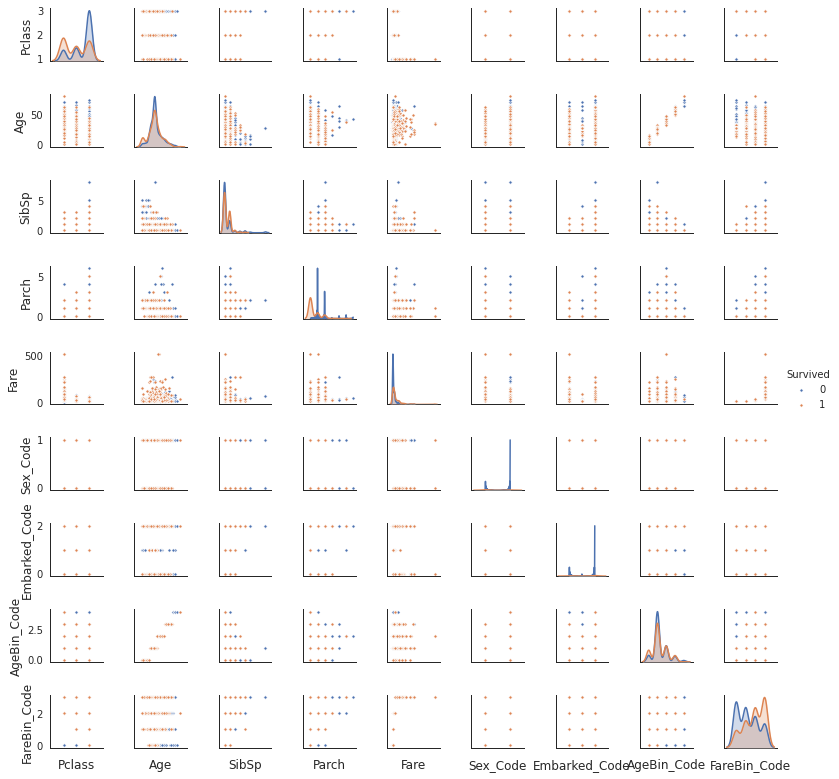

In [ ]:
#pair plots of entire dataset
pp = sns.pairplot(data1, hue = 'Survived', 
                  palette = 'deep',
                  size=1.2, 
                  diag_kind = 'kde',
                  diag_kws=dict(shade=True),
                  plot_kws=dict(s=10) )
pp.set(xticklabels=[])

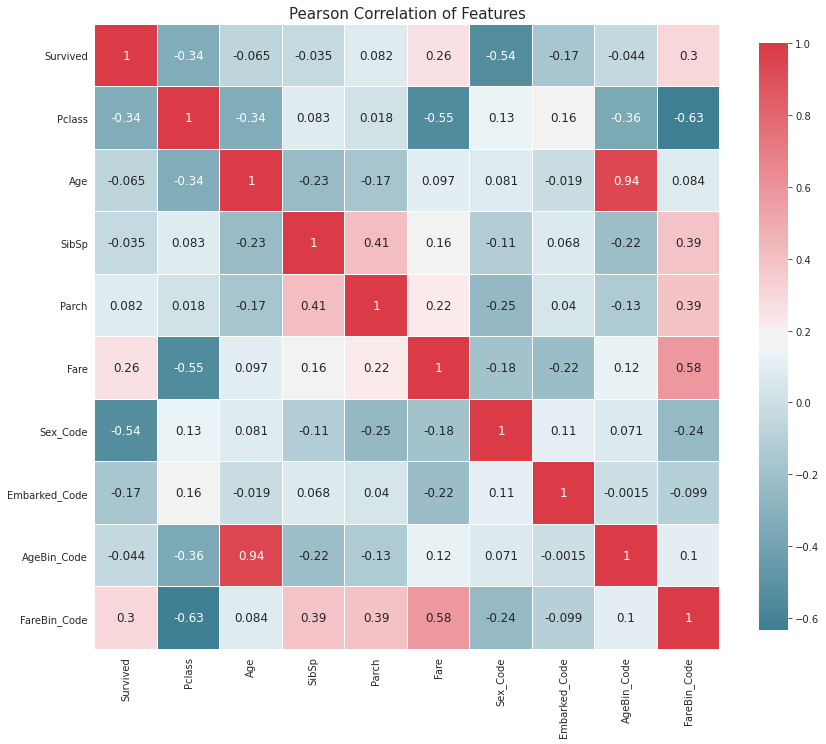

In [ ]:
#correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1)


In [ ]:
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.BaggingClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    #Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(),
    linear_model.PassiveAggressiveClassifier(),
    linear_model.RidgeClassifierCV(),
    linear_model.SGDClassifier(),
    linear_model.Perceptron(),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.NuSVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis(),

    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]

In [ ]:
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters','MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)
#create table to compare MLA predictions
MLA_predict = data1[Target]

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, data1[data1_x_bin], data1[Target],  return_train_score=True, cv  = cv_split)
    print(cv_results)
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!
    

    #save MLA predictions - see section 6 for usage
    alg.fit(data1[data1_x_bin], data1[Target])
    MLA_predict[MLA_name] = alg.predict(data1[data1_x_bin])
    
    row_index+=1
   
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare
#MLA_predict
MLA 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

{'fit_time': array([0.07137823, 0.06715465, 0.06995535, 0.06949973, 0.06712389,
       0.06956363, 0.06753731, 0.07219338, 0.08109021, 0.06823659]), 'score_time': array([0.00882411, 0.00844383, 0.00832677, 0.00850272, 0.00882125,
       0.00839448, 0.00937438, 0.00889087, 0.00840425, 0.00836706]), 'test_score': array([0.78358209, 0.76119403, 0.80597015, 0.73880597, 0.79477612,
       0.7761194 , 0.7761194 , 0.77238806, 0.76119403, 0.80597015]), 'train_score': array([0.80149813, 0.8071161 , 0.77902622, 0.82397004, 0.77902622,
       0.80337079, 0.79400749, 0.77153558, 0.79962547, 0.78651685])}


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

{'fit_time': array([0.02229118, 0.01760674, 0.01672196, 0.0193994 , 0.02006602,
       0.01656556, 0.01692986, 0.01657152, 0.01662731, 0.0165956 ]), 'score_time': array([0.00388718, 0.00237298, 0.00237226, 0.00239062, 0.00245285,
       0.00233793, 0.0023191 , 0.00225854, 0.00234771, 0.00229406]), 'test_score': array([0.79477612, 0.81716418, 0.79477612, 0.78731343, 0.80223881,
       0.77985075, 0.78731343, 0.75746269, 0.7761194 , 0.83955224]), 'train_score': array([0.85580524, 0.85205993, 0.84831461, 0.85393258, 0.84269663,
       0.86142322, 0.85018727, 0.83520599, 0.85580524, 0.83520599])}


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_bagging.py:645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWa

{'fit_time': array([0.10390568, 0.1055305 , 0.09719777, 0.10791945, 0.10392714,
       0.10168791, 0.09638023, 0.09973788, 0.10135245, 0.1027379 ]), 'score_time': array([0.01086879, 0.01093197, 0.01070261, 0.01124907, 0.012254  ,
       0.01064491, 0.01063395, 0.01078105, 0.01070857, 0.01081848]), 'test_score': array([0.80597015, 0.81343284, 0.77985075, 0.81343284, 0.81716418,
       0.76119403, 0.81343284, 0.79477612, 0.75746269, 0.85074627]), 'train_score': array([0.85580524, 0.85580524, 0.85580524, 0.8576779 , 0.84456929,
       0.86329588, 0.85580524, 0.84082397, 0.85955056, 0.83520599])}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

{'fit_time': array([0.07212496, 0.07247615, 0.07058334, 0.06852961, 0.06719136,
       0.06730366, 0.07768273, 0.06779051, 0.06652617, 0.06888223]), 'score_time': array([0.0027101 , 0.00184274, 0.00180602, 0.00184274, 0.00179124,
       0.00180244, 0.00209808, 0.00185132, 0.00186658, 0.0018816 ]), 'test_score': array([0.81716418, 0.82462687, 0.81716418, 0.80597015, 0.82089552,
       0.79104478, 0.79850746, 0.81343284, 0.79850746, 0.82835821]), 'train_score': array([0.84644195, 0.84082397, 0.83895131, 0.85018727, 0.83146067,
       0.84644195, 0.84456929, 0.83520599, 0.85205993, 0.81835206])}


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarnin

{'fit_time': array([0.14101243, 0.13918114, 0.13628912, 0.13656759, 0.14099407,
       0.13163495, 0.1360507 , 0.13099051, 0.16083097, 0.13297653]), 'score_time': array([0.01057005, 0.01076484, 0.01047707, 0.01130676, 0.01097178,
       0.01195216, 0.01054811, 0.01082897, 0.01112103, 0.01075101]), 'test_score': array([0.79477612, 0.78731343, 0.77985075, 0.80970149, 0.81716418,
       0.76865672, 0.80597015, 0.79477612, 0.79477612, 0.83955224]), 'train_score': array([0.85580524, 0.85580524, 0.85393258, 0.8576779 , 0.84456929,
       0.86329588, 0.85580524, 0.84082397, 0.85955056, 0.83520599])}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed w

{'fit_time': array([0.16520572, 0.15465355, 0.13600183, 0.14734077, 0.1410706 ,
       0.15054369, 0.13405466, 0.1434238 , 0.13142586, 0.1590786 ]), 'score_time': array([0.00815129, 0.00808978, 0.01667261, 0.00800681, 0.00826454,
       0.00804496, 0.00784755, 0.00792217, 0.0078795 , 0.00787878]), 'test_score': array([0.81343284, 0.79104478, 0.80597015, 0.78731343, 0.80970149,
       0.76492537, 0.79850746, 0.79477612, 0.77985075, 0.83955224]), 'train_score': array([0.83707865, 0.83146067, 0.83520599, 0.84082397, 0.82771536,
       0.84644195, 0.83895131, 0.82958801, 0.85205993, 0.8164794 ])}


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed w

{'fit_time': array([0.18606114, 0.18322587, 0.14166188, 0.17202067, 0.14094877,
       0.16187477, 0.14419103, 0.2005024 , 0.1519978 , 0.19554663]), 'score_time': array([0.00108528, 0.00102687, 0.00101352, 0.00102973, 0.00098419,
       0.00097656, 0.00105858, 0.00106215, 0.00107908, 0.00102735]), 'test_score': array([0.78731343, 0.76492537, 0.78731343, 0.75746269, 0.80223881,
       0.7761194 , 0.79477612, 0.7761194 , 0.79477612, 0.80970149]), 'train_score': array([0.79962547, 0.8071161 , 0.78089888, 0.82022472, 0.78089888,
       0.79962547, 0.7752809 , 0.7752809 , 0.78089888, 0.79026217])}


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed w

{'fit_time': array([0.00350928, 0.00287414, 0.00279164, 0.00253749, 0.00276804,
       0.00264049, 0.00348663, 0.00445819, 0.0047729 , 0.00273585]), 'score_time': array([0.00090885, 0.00081444, 0.00077438, 0.00079966, 0.00079036,
       0.00082254, 0.0012958 , 0.00135326, 0.00084233, 0.00082207]), 'test_score': array([0.77238806, 0.6119403 , 0.64925373, 0.72014925, 0.79104478,
       0.74253731, 0.68656716, 0.77985075, 0.7761194 , 0.81343284]), 'train_score': array([0.77340824, 0.6329588 , 0.62734082, 0.71722846, 0.74344569,
       0.75468165, 0.68164794, 0.77153558, 0.78651685, 0.76966292])}
{'fit_time': array([0.02440166, 0.00454378, 0.00413704, 0.00405073, 0.00400758,
       0.00429702, 0.00412726, 0.00419593, 0.0039475 , 0.00395012]), 'score_time': array([0.00106025, 0.00087309, 0.0008657 , 0.00086355, 0.0008657 ,
       0.00089121, 0.00086498, 0.00083637, 0.00085664, 0.00086188]), 'test_score': array([0.78358209, 0.75373134, 0.79850746, 0.76492537, 0.78731343,
       0.78358209, 0

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

{'fit_time': array([0.00281501, 0.00270915, 0.00274229, 0.00411582, 0.00517988,
       0.00429344, 0.0029006 , 0.00304842, 0.00295687, 0.00275993]), 'score_time': array([0.0008359 , 0.00079274, 0.0008471 , 0.00137734, 0.00121117,
       0.00093746, 0.00079417, 0.00083542, 0.00079036, 0.00080276]), 'test_score': array([0.67537313, 0.75373134, 0.6380597 , 0.73507463, 0.74253731,
       0.67910448, 0.79850746, 0.70522388, 0.69029851, 0.80597015]), 'train_score': array([0.65917603, 0.79775281, 0.61235955, 0.8071161 , 0.75655431,
       0.68539326, 0.77715356, 0.72846442, 0.68164794, 0.7752809 ])}
{'fit_time': array([0.00290155, 0.00258923, 0.00250983, 0.00253177, 0.00248146,
       0.00256419, 0.00251293, 0.00255251, 0.00344205, 0.00289273]), 'score_time': array([0.00096869, 0.0009377 , 0.00093555, 0.00091624, 0.00092053,
       0.00094533, 0.00092363, 0.00093508, 0.00156379, 0.00097275]), 'test_score': array([0.78358209, 0.77985075, 0.78731343, 0.75      , 0.77238806,
       0.76119403, 0

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when

{'fit_time': array([0.00694036, 0.00930381, 0.00303507, 0.00292253, 0.0032444 ,
       0.00292993, 0.00286937, 0.00333977, 0.00379348, 0.00298858]), 'score_time': array([0.00899434, 0.01223159, 0.00870037, 0.00857496, 0.00869799,
       0.00842476, 0.00891495, 0.0100379 , 0.00900149, 0.00880837]), 'test_score': array([0.80597015, 0.77238806, 0.80597015, 0.79850746, 0.79850746,
       0.74253731, 0.79104478, 0.79850746, 0.80223881, 0.85074627]), 'train_score': array([0.83895131, 0.83895131, 0.83707865, 0.83895131, 0.82397004,
       0.84644195, 0.83520599, 0.82771536, 0.84082397, 0.82022472])}


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

{'fit_time': array([0.03536677, 0.03491902, 0.03896451, 0.03584218, 0.03458643,
       0.03358436, 0.03723073, 0.03843951, 0.0357337 , 0.04208088]), 'score_time': array([0.00317669, 0.00299597, 0.00324988, 0.00290728, 0.00317669,
       0.00345731, 0.00309348, 0.00320029, 0.00488377, 0.00326943]), 'test_score': array([0.80970149, 0.80223881, 0.82089552, 0.77985075, 0.80970149,
       0.79104478, 0.80970149, 0.80597015, 0.79104478, 0.83955224]), 'train_score': array([0.81273408, 0.81835206, 0.80898876, 0.8258427 , 0.81273408,
       0.82209738, 0.83146067, 0.80524345, 0.81460674, 0.80149813])}


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

{'fit_time': array([0.04683399, 0.04432201, 0.04705   , 0.04057384, 0.04310322,
       0.03968167, 0.04083514, 0.0411694 , 0.04346013, 0.04371047]), 'score_time': array([0.00339007, 0.00382972, 0.00339746, 0.00408912, 0.00332093,
       0.00338793, 0.00319028, 0.00318336, 0.00321007, 0.00343847]), 'test_score': array([0.80223881, 0.78731343, 0.80223881, 0.76865672, 0.80970149,
       0.79850746, 0.80970149, 0.79104478, 0.79477612, 0.83955224]), 'train_score': array([0.81273408, 0.8164794 , 0.81086142, 0.8258427 , 0.81273408,
       0.82209738, 0.83146067, 0.79962547, 0.80524345, 0.80149813])}


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

{'fit_time': array([0.02638483, 0.02387238, 0.02545238, 0.02428031, 0.02432513,
       0.02372932, 0.02585435, 0.0170362 , 0.0228374 , 0.02656531]), 'score_time': array([0.00183797, 0.0010891 , 0.00153112, 0.00102687, 0.00107408,
       0.00107384, 0.00113368, 0.00106096, 0.001724  , 0.00149488]), 'test_score': array([0.78731343, 0.75373134, 0.79850746, 0.76492537, 0.78731343,
       0.78358209, 0.79850746, 0.7761194 , 0.79477612, 0.80223881]), 'train_score': array([0.78089888, 0.79962547, 0.7752809 , 0.81273408, 0.77715356,
       0.79400749, 0.78464419, 0.78838951, 0.79213483, 0.77340824])}
{'fit_time': array([0.00294209, 0.00267577, 0.00256634, 0.00250864, 0.00248957,
       0.00251436, 0.00252295, 0.00252366, 0.00261331, 0.00255823]), 'score_time': array([0.00100803, 0.00088334, 0.00089049, 0.00083709, 0.00084376,
       0.00083852, 0.00087237, 0.00086761, 0.00089598, 0.00085092]), 'test_score': array([0.80223881, 0.81343284, 0.78731343, 0.80223881, 0.82089552,
       0.75746269, 0

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

{'fit_time': array([0.00334048, 0.00320458, 0.00323367, 0.00310969, 0.00304079,
       0.00459075, 0.00321102, 0.00308466, 0.00342655, 0.00476861]), 'score_time': array([0.0009532 , 0.00086737, 0.00089836, 0.00092196, 0.00166345,
       0.0013144 , 0.00088143, 0.0010705 , 0.00200844, 0.00132966]), 'test_score': array([0.78358209, 0.75373134, 0.79850746, 0.76492537, 0.78731343,
       0.78358209, 0.79850746, 0.7761194 , 0.79104478, 0.80223881]), 'train_score': array([0.78089888, 0.79962547, 0.7752809 , 0.81273408, 0.77715356,
       0.79213483, 0.78277154, 0.78838951, 0.79213483, 0.77340824])}
{'fit_time': array([0.00293922, 0.00251126, 0.00335121, 0.00369763, 0.00280356,
       0.00249577, 0.00241327, 0.00242949, 0.00243139, 0.00243926]), 'score_time': array([0.00119615, 0.0010376 , 0.00180531, 0.00186324, 0.00108123,
       0.001091  , 0.00100732, 0.00101018, 0.00099897, 0.00102472]), 'test_score': array([0.79104478, 0.75746269, 0.80970149, 0.75      , 0.81343284,
       0.79850746, 0

[AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                    n_estimators=50, random_state=None),
 BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=False,
                   max_features=1.0, max_samples=1.0, n_estimators=10,
                   n_jobs=None, oob_score=False, random_state=None, verbose=0,
                   warm_start=False),
 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                      criterion='gini', max_depth=None, max_features='auto',
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None, verbose=0,
                      warm_start=False),
 GradientBoostingClassifier(ccp_alpha=0.0, criterio

In [ ]:
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
21,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",0.83633,0.815299,0.0566931,0.0363926
3,GradientBoostingClassifier,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",0.840449,0.811567,0.035487,0.0699091
14,SVC,"{'C': 1.0, 'break_ties': False, 'cache_size': ...",0.815356,0.80597,0.0477554,0.0366748
2,ExtraTreesClassifier,"{'bootstrap': False, 'ccp_alpha': 0.0, 'class_...",0.852434,0.800746,0.0804414,0.102038
17,DecisionTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.852434,0.800373,0.082601,0.00259149
15,NuSVC,"{'break_ties': False, 'cache_size': 200, 'clas...",0.813858,0.800373,0.0520853,0.043074
18,ExtraTreeClassifier,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit...",0.852434,0.799254,0.0844834,0.00244501
4,RandomForestClassifier,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",0.852247,0.799254,0.0570347,0.138653
5,GaussianProcessClassifier,"{'copy_X_train': True, 'kernel': None, 'max_it...",0.835581,0.798507,0.0581659,0.14628
13,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.834831,0.796642,0.0775949,0.00413673
